In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
cwd = Path.cwd()
ROOT_PATH = str(cwd.parent.parent.parent.parent)

sys.path.append(ROOT_PATH)

from simpml.tabular.all import *
np.random.seed(0)
%matplotlib inline

# Tabular Supervised Use Cases

## Overview

This notebook presents a guide to using SimpML, with specific focus on tabular data. It demonstrates various use cases including binary classification, multi-class classification, regression, and root-cause analysis.

The key steps covered in this notebook include:

1. Data Manager: Preprocess and manipulate the data, including pipeline construction, data distribution for training and testing, and more.
2. Experiment Manager: Easily run experiments with multiple models and evaluate their performance.
3. Interpreter: Gain insights into models' behavior, feature importance, and detect issues.
4. Inference: Make predictions using selected models during inference.
 
Let's dive into each use case and see how SimpML simplifies the machine learning process.

## Binary Classification

### Data Manager

We will demonstrate this use case using the Titanic binary classification dataset.

Here are the key steps:

- Data Loading: We create a SupervisedTabularDataManager instance, specifying the dataset file path, target variable ('Survived'), and prediction type as binary classification.
- Preprocessing: SimpML's data management capabilities are leveraged to preprocess the data. The build_pipeline method is called to construct a pipeline for data preprocessing, including dropping unnecessary columns such as 'PassengerId'.

Suppose we want other split values, we can easily initialize the splitter manually:

In [2]:
data_manager = SupervisedTabularDataManager(data = DataSet.load_titanic_dataset(),
                                            target = 'Survived',
                                            prediction_type = PredictionType.BinaryClassification,
                                            splitter = RandomSplitter(split_sets = {Dataset.Train: 0.8, Dataset.Valid: 0.2}, target = 'Survived'))

In [3]:
data_manager.splitter.split_sets

{<Dataset.Train: 'Train'>: 0.8, <Dataset.Valid: 'Valid'>: 0.2}

By using the build_pipeline method, SimpML provides a convenient and customizable way to build a preprocessing pipeline tailored for binary classification tasks. This simplifies the preliminary data processing step and lays the foundation for training and evaluation of subsequent models Let's see how the initialization of the pipeline looks like.

In [4]:
data_manager.build_pipeline(drop_cols = ['PassengerId'])

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
MatchVariablesAfter (MatchVariables(missing_val

The build_pipeline method in SimpML's SupervisedTabularDataManager class is responsible for constructing a machine learning pipeline for preprocessing the data such as: missing value handling, categorical variable handling, data balancing, target encoding, features removal end more.
 
It offers a range of capabilities to handle various preprocessing tasks and provides default values for ease of use.


The build_pipeline method adapts to different problems by adjusting its default settings based on the "prediction_type" argument. This provides a fitting initial setup for users. However, for maximum personalization, users can override these defaults by passing in different argument values, offering both standardization and customization in an efficient package. Let's see how it can be done easily:

In [5]:
data_manager.build_pipeline(drop_cols = ['PassengerId'], smote = False)

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
MatchVariablesAfter (MatchVariables(missing_val

### Experiment Manager

Next, we'll leverage SimpML's Experiment Manager to automatically build and compare multiple models, using common evaluation metrics such as accuracy, AUC, recall, and precision.

The ExperimentManager is an advanced tool of the SimpML library that allows the user to experiment with a wide range of machine learning models and evaluate their performance based on various metrics.

To initialize the ExperimentManager, it takes two parameters:

 - data_manager: The DataManager object which encapsulates your dataset and includes information about features and targets.

 - optimize_metric: This is the metric that you want to optimize. It is of the Enum type, MetricName, and can be Accuracy, Precision, Recall, AUC, F1, etc. By default, it is set to Accuracy.

In [6]:
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.AUC)

After initializing the experiment manager we can see the models available for our experiment. These models are initialized according to the type of data and the type of problem defined in the data manager.

You can easily omit certain models from the list or add custom models.

The table below describes the main features of each model, including their names, descriptions, sources and availability statuses.

In [7]:
exp_mang.display_models_pool()

Let's see how we can omit a certain model or models (You can send a single model or a list of models):

In [8]:
exp_mang.remove_models('Gradient Boosting')

We see that now only three models remain available:

In [9]:
exp_mang.get_available_models_df()

Description
Baseline Classification    Default settings
Logistic Regression        Default settings
Support Vector Classifier  Default settings
AdaBoost Classifier        Default settings
Decision Tree              Default settings
Random Forest              Default settings
XGBoost                    Default settings
LightGBM                   Default settings

Note: There is an option to add customized models to the list of available models. To see how to do this go to the "Experiment Manager Components" page under the "Add Custom Models" section

If necessary, we can reset the list of models back to the default. This action will undo the model removals that have been made and delete custom models that have been added:

In [10]:
exp_mang.reset_models()

Similarly, you can review the metrics that will be started by default and see who is slamming it we want to optimize:

In [11]:
exp_mang.display_metrics_pool()

Once the ExperimentManager is initialized, you can use the fit_suite function to fit multiple models on the data encapsulated in the provided DataManager object.

You can see how you can send parameters to the metrics we are going to calculate using the metrics_kwargs dictionary.
If the metric has a parameter name of a key in our dictionary, the experiment manager will calculate the metric with this parameter.
In the example below we send a variable "pos_label" that will affect the metrics of a binary classification

In [12]:
exp_mang.run_experiment(metrics_kwargs = {'pos_label': 1})

The fit_suite function will return a pandas DataFrame summarizing the experiments. It includes:

 - Experiment ID: An unique identifier for each run.
 - Experiment Description: Experiment description that was provided in run_experiment
 - Model Description: The name of the machine learning model used.
 - Description: A short description about the model.
 - Data Version: The version of the data used for the experiment.
 - Data Description: A short description of the data used.
 - Model Params: The parameters used by the model.
 - Metric Params: The parameters used for the performance metrics.
 - Various metrics: The values for different metrics like Accuracy, AUC, Recall, Precision, BalancedAccuracy, F1.
 - Run Time: The total time taken by each model to train and make predictions.

The get_best_model function can be used to retrieve the model that performed the best according to the optimize_metric.

In [13]:
best_model = exp_mang.get_best_model()
best_model

Model: LogisticRegression(n_jobs=-1, random_state=42), Description: Default settings

Alternatively, we can retrieve any other trained model from the experiment manager using get_model_by_name function and sending the model name and its Experiment ID:

In [14]:
exp_id = exp_mang.get_current_experiment_id()
exp_id

'20240813142229_4df0'

In [15]:
light_gbm = exp_mang.get_model(model_name = 'LightGBM', experiment_id = exp_id)

#### Logger


In the Experiment Manager, users have the option to utilize a logger, enabling the storage of experiments in a persistent manner. They can choose from a selection of pre-defined loggers or create a custom one according to their needs. Next, we will explore how to work with the MLflow logger.

As part of Experiment Manager init, we can send the logger

In [16]:
#exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.AUC, logger = MlflowLogger('my_projrct_name'))

In [17]:
#exp_mang.run_experiment(experiment_description='Mlflow Demo', metrics_kwargs = {'pos_label': 1})

In [18]:
#exp_mang.get_best_model()

Our experimnt is now saved in MLFlow with parameters, metrics & tags. We have summary row representing best model with our data manager & model pipeline saved as artifacts 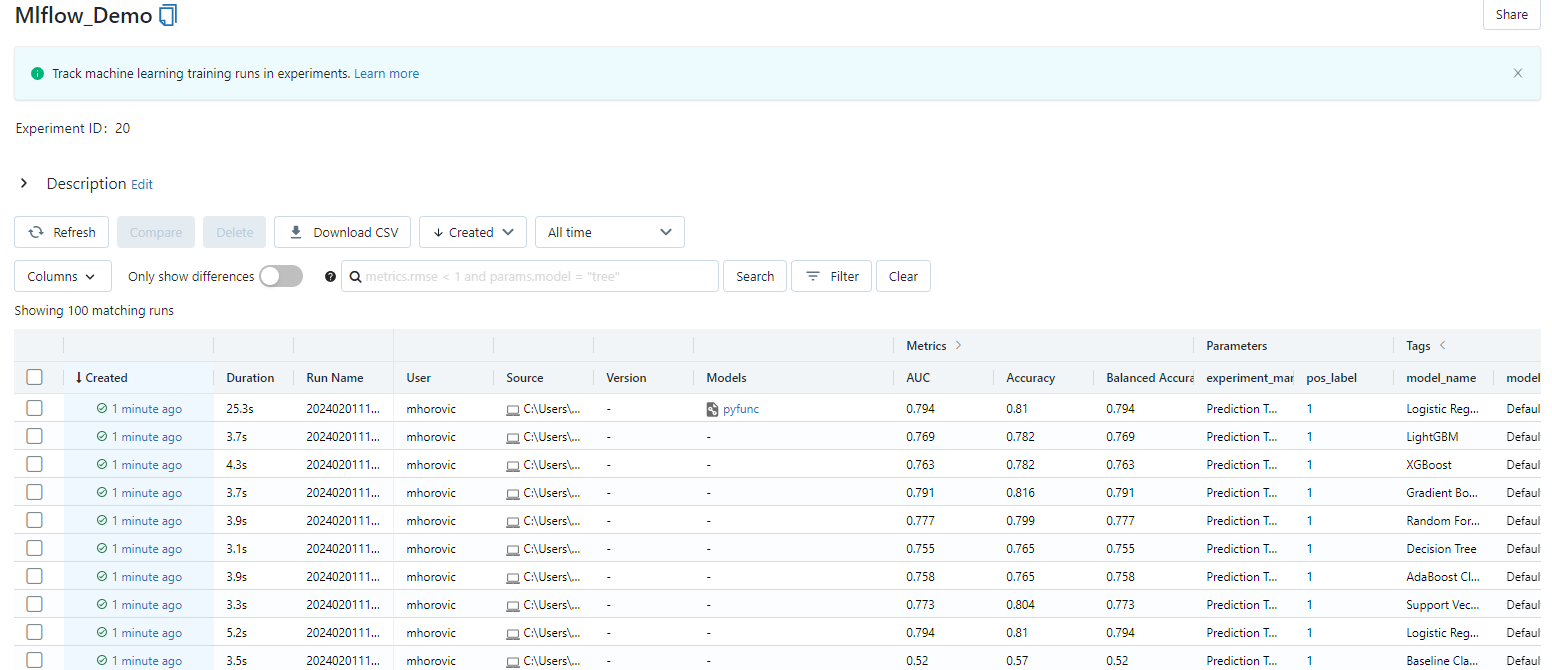

In order to reperduce run from MlFlow Experiment back to notebook, you can use the following util. By default you will get pointer to latest run but you can send run_name & tags to get different one.

In [19]:
#mlflow_run_handler = exp_mang.logger.get_run_handler()

In [20]:
#mlflow_run_handler.run_name

In [21]:
#mlflow_run_handler.load_model()

In [22]:
#mlflow_run_handler.load_model_pipeline()

In [23]:
#mlflow_run_handler.load_data_manager()

In [24]:
#exp_mang = mlflow_run_handler.load_experiment_manager()
#exp_mang.run_experiment(metrics_kwargs = {'pos_label': 1})

### Interpreter

In the world of machine learning and data science, model interpretability and understanding is critical. It's not enough to have a model that simply makes accurate predictions; we also need to understand why it makes those decisions and if there are any inherent flaws or biases in the model. This is where the Interpreter comes in.

Once the models are trained, SimpML provides an intuitive way to interpret the results. We'll create a Binary Classification Interpreter to analyze the model's performance on the dataset.


In [25]:
interp = TabularInterpreterBinaryClassification(model = light_gbm,
                                                data_manager = data_manager,
                                                opt_metric = exp_mang.opt_metric,
                                                pos_class = {'pos_class' : 1})


#### Shap

The interpreter provides an easy way to plot a variety of shape values:

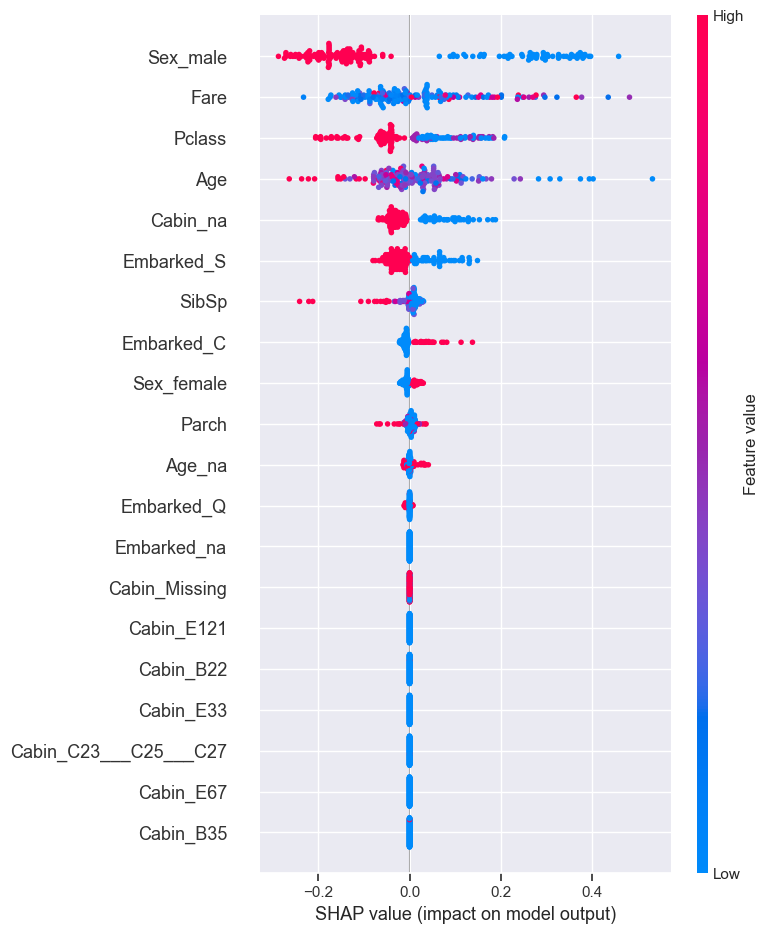

In [26]:
interp.shap_manager.plot_summary_shap()

By default, the interpreter functions will run on the validation set, but we can easily override them like this:

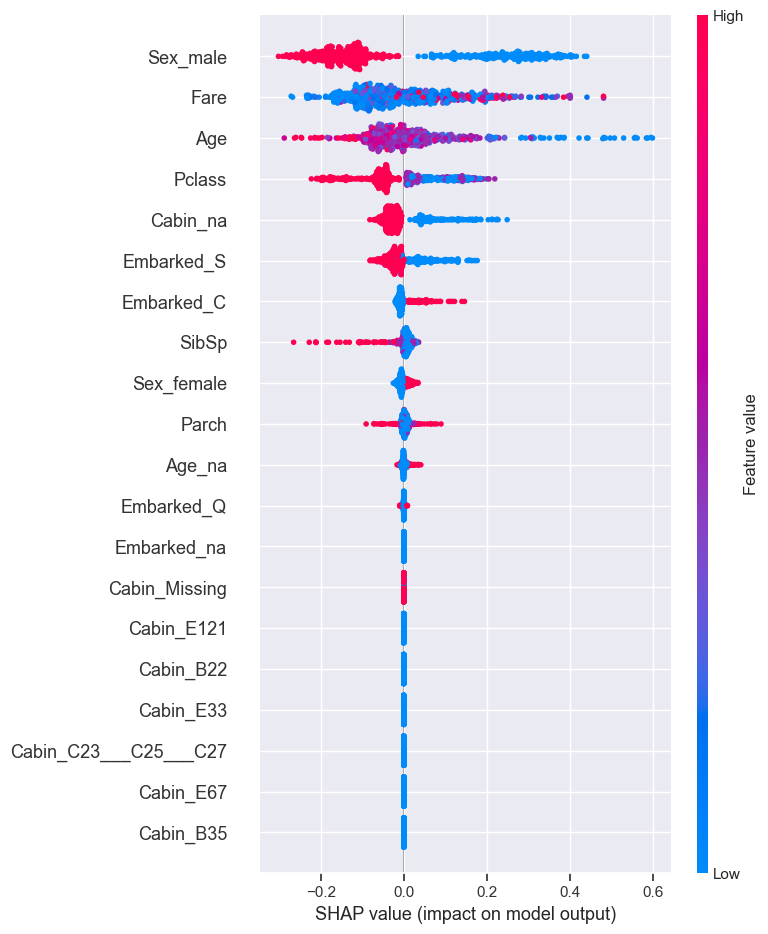

In [27]:
X,y = data_manager.get_training_data()
interp.shap_manager.plot_summary_shap(X)

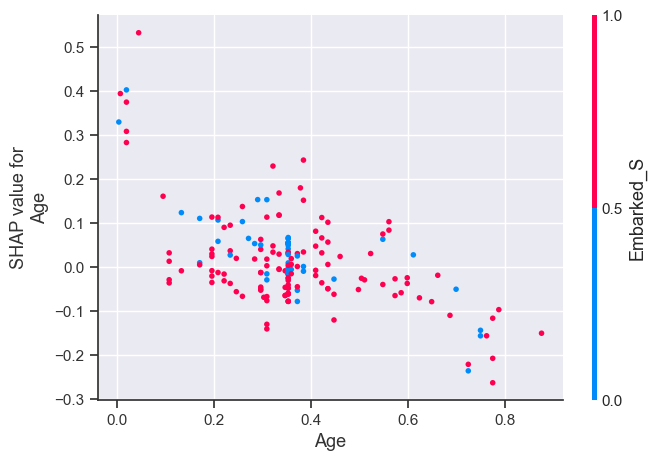

In [28]:
interp.shap_manager.plot_shap_dependence('Age')

#### Analysis of the model predictions

First, we can plot the confusion matrix, also here the default is to display it on the validation set. To display it on another set we will have to send this set to the function

In [29]:
interp.plot_confusion_matrix()

The interp.find_best_threshold() method is used to find the optimal decision threshold for our model. In binary classification, this threshold is the cutoff for classifying an instance as positive (1) or negative (0).confusion matrix
 The optimal threshold maximizes our model's performance based on the metric we specified in our Experiment Manager.

By default, this threshold is often set to 0.5, but it can vary depending on the data and task. Adjusting it can help balance precision and recall, or minimize false positives or negatives.

When calling this function without arguments, it uses the data and optimization metric specified when initiating our interpreter.

Now, let's find the best threshold for our model:

In [30]:
interp.find_best_threshold()

We can also visually see the distribution of the probability of the model's predictions

In [31]:
interp.get_probability_plot()

The plot_roc_curve() method is used to generate and display the Receiver Operating Characteristic (ROC) curve for your model. The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR).

In [32]:
interp.plot_roc_curve()

The plot_fpr_tpr_curve() method, which is similar to the plot_roc_curve() method, generates and displays the Receiver Operating Characteristic (ROC) curve for a model. The ROC curve is a graphical plot that demonstrates the diagnostic ability of a binary classifier system.

In [33]:
interp.plot_fpr_tpr_curve()

The plot_feature_importance() function is used to create a graphical representation of the importance of various features in your model. The interpreter supports two methods for calculating the importance of features: Shape and Permutation.

- Shap: The SHAP (SHapley Additive Explanations) method calculates the contribution of each feature to the prediction for each instance. It assigns each attribute an importance score for a particular prediction. A higher SHAP value means a higher contribution to the prediction. SHAP values ​​have a 'game theoretic' property where the sum of SHAP values ​​for all attributes equals the difference between the prediction and the baseline (expected) value.

- Permutation: Permutation feature importance is a technique used to estimate the importance of input features by calculating the increase in prediction error after changing the feature values, which breaks the relationship between the feature and the true result. The idea is that the importance of an attribute is proportional to the increase in the prediction error of the model after changing the attribute values.

Let's see how we can get the feature importance according to each method:

In [34]:
interp.plot_feature_importance(method = FeatureImportanceMethod.Shap)

In [35]:
interp.plot_feature_importance(method = FeatureImportanceMethod.Permutation)

In the next step, we'll assemble an interactive dashboard that includes all the plots related to our model's prediction analysis. This platform allows you to adjust the threshold indicator, the pivot point distinguishing between normal and abnormal outcomes, and directly observe how this adjustment influences the predictions made by the model.

Let's see how to do it:

In [36]:
interp.main_fig()

#### Mlflow logger

You can use mlflow run handler util to save interepret plots & figures to mlflow

In [37]:
#mlflow_run_handler.log_figure(interp.main_fig(), "main_fig.html")

#### Insights

In machine learning, insights provide a deeper understanding of our models. They reveal relationships between features and outcomes, identify data issues like noise or leakage, and guide the improvement and debugging of the model. By leveraging these insights, we can enhance model performance and reliability.

First, we can get the feature importance as a data frame table to further explore it later. Let's do it like this:

In [38]:
interp.get_feature_importance(method = FeatureImportanceMethod.Shap)

col_name  feature_importance_vals
0                 Sex_male                 0.342859
1                     Fare                 0.164667
2                   Pclass                 0.133336
3                      Age                 0.126205
4                 Cabin_na                 0.075318
..                     ...                      ...
137              Cabin_B35                 0.000000
138              Cabin_E67                 0.000000
139  Cabin_C23___C25___C27                 0.000000
140              Cabin_E33                 0.000000
141       Embarked_Missing                 0.000000

[142 rows x 2 columns]

The get_noisy_features() method uses SHAP to identify 'noisy' features - those contributing more to overfitting than to model accuracy. 

This function computes correlation between SHAP values and feature values; high correlation signifies more important features while low correlation suggests overfitting potential.

The method iteratively analyzes and possibly drops noisy features if model performance improves, stopping when performance ceases to improve.

Let's find noisy features in our data:

In [39]:
noisy_features = interp.get_noisy_features()

Bad noisy feature found: Age_na
old AUC: 0.7687 new AUC: 0.7687
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       110
           1       0.72      0.71      0.72        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



In [40]:
noisy_features

['Age_na']

The leakage_detector() method is designed to identify and locate features suspected of causing data leakage. 

It achieves this by comparing the performance of a model trained on all features against one trained on only the most important feature. If the performance difference is smaller than a specified epsilon or if the second model performs better, data leakage is suspected.

In [41]:
is_leakage = interp.leakage_detector()

Suspected data leakage detected! feature Sex_male
Model results with the all the data: 0.7702040275569688 AUC
Model results with this feature only: 0.7671575437621562 AUC
The difference between the results of the models is 0.003046483794812649 < smaller than 0.05


In [42]:
is_leakage

True

#### Actions

Finally, we can harness the insights derived from the interpreter to refine our data, subsequently initiating a new experiment to enhance our model!

Here's how we can go about this:

In [43]:
noisy_features

['Age_na']

In this example we discovered that we have a noisy feature, a feature that does not contribute to the performance of the model and may cause overfitting. Let's create a new pipeline without this feature:

In [44]:
new_data_manager_without_noisy_features = data_manager.clone()
new_data_manager_without_noisy_features.set_description('Noisy Features Dropped')
new_data_manager_without_noisy_features.build_pipeline(drop_cols = ['PassengerId'] + noisy_features, smote = False)

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId', 'Age_na'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['Age_na', 'PassengerId'])) ->
MatchVariablesAfter (MatchV

We will load the new version of the data back to the experiment manager:

In [45]:
exp_mang.set_new_data(new_data_manager_without_noisy_features)

aedef98e

And we will run a new experiment on this data:

In [46]:
exp_mang.run_experiment()

In the new experiment we conducted we improved the performance of the model using the insights we received from the interpreter!

### Inference

Will be supported soon

## Multi-Class Classification

#### Data Manager

In this use case, we will use the Shelter Animal Outcomes dataset for a multi-class classification task.

Here are the key steps:

 - Data Loading: We instantiate a SupervisedTabularDataManager object, specifying the dataset file path, target variable ('OutcomeType'), and prediction type as multi-class classification.
 - Preprocessing: We leverage SimpML's data management capabilities to preprocess the data. The build_pipeline method is invoked to construct a pipeline for data preprocessing. This may include dropping unnecessary columns or transforming variables, depending on the specific requirements of the dataset. For instance, columns like 'AnimalID' or 'Name' which may not contribute to the prediction of the outcome can be dropped.

In [47]:
data_manager = SupervisedTabularDataManager(data = DataSet.load_wine_dataset(),
                                            target = 'target',
                                            prediction_type = PredictionType.BinaryClassification,
                                           )
data_manager.build_pipeline()

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
MatchVariablesAfter (MatchVariables(missing_values='ignore'))

Target Pipeline:
LabelEncoder (DictLabelEncoder())

In [48]:
splitter = RandomSplitter(split_sets = {Dataset.Train: 0.6, Dataset.Valid: 0.2, Dataset.Test: 0.2}, target = 'target')
data_manager = SupervisedTabularDataManager(data = DataSet.load_wine_dataset(),
                                            target = 'target',
                                            prediction_type = PredictionType.MulticlassClassification,
                                            splitter = splitter)

In [49]:
data_manager.data_fetcher.get_items()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  target  
0                            3.92   1065.0       0  
1                            3.40   1050.0       0  
2                            3.17   1185.0       0  
3                            3.45   1480.0       0  
4                            2.93    735.0       0  
..                            ...      ...     ...  
173                          1.74    740.0       2  
174                          1.56    750.0       2  
175                          1.56    835.0       2  
176                          1.62    840.0       2  
177                          1.60    560.0       2  

[178 rows x 14 columns]

In [50]:
data_manager.build_pipeline()

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
MatchVariablesAfter (MatchVariables(missing_values='ignore'))

Target Pipeline:
LabelEncoder (DictLabelEncoder())

### Experiment Manager

In [51]:
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.Accuracy)
exp_mang.display_models_pool()

In [52]:
exp_mang.run_experiment()

In [53]:
best_model = exp_mang.get_best_model()
best_model

Model: SVC(probability=True, random_state=42), Description: Default settings

### Interpreter

In [54]:
interp = TabularInterpreterClassification(model = exp_mang.get_model('Decision Tree', experiment_id = exp_mang.get_current_experiment_id()),
                                          data_manager = data_manager,
                                          opt_metric = exp_mang.opt_metric,
                                          pos_class = {'pos_class' : 1})

In [55]:
interp.get_label_density_plot()

In [56]:
interp.main_fig()

## Regression

### Data Manager

In [57]:
data_manager = SupervisedTabularDataManager(data = DataSet.load_fetch_california_housing_dataset(),
                                            target = 'MedHouseVal',
                                            splitter = RandomSplitter(split_sets = {Dataset.Train: 0.8, Dataset.Valid: 0.2}, target = 'MedHouseVal', stratify = False),
                                            prediction_type = PredictionType.Regression)
data_manager.build_pipeline()

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
MatchVariablesAfter (MatchVariables(missing_values='ignore'))

### Experiment Manager

In [58]:
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.MSE)
exp_mang.run_experiment()

### Interpreter

In [59]:
interp = TabularInterpreterRegression(exp_mang.get_model('XGBoost', exp_mang.get_current_experiment_id()),
                                      data_manager, exp_mang.opt_metric)

 94%|=================== | 3872/4128 [00:14<00:00]         

In [60]:
interp.main_fig()

## RCA

### Data Manager

In [61]:
data_manager = SupervisedTabularDataManager(data = DataSet.load_titanic_dataset(),
                                            target = 'Survived',
                                            splitter = 'RCA',\
                                            prediction_type = PredictionType.BinaryClassification)
data_manager.build_pipeline(drop_cols = ['PassengerId'])

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
MatchVariablesAfter (MatchVariables(missing_val

### Experiment Manager

In [62]:
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.Accuracy)
exp_mang.remove_models(['Gradient Boosting', 'LightGBM', 'BaselineClassification', 'XGBoost'])
exp_mang.run_experiment()

### Interpreter

In [63]:
interp = TabularInterpreterBinaryClassification(model = exp_mang.get_best_model(),
                                                data_manager = data_manager,
                                                opt_metric = exp_mang.opt_metric,
                                                pos_class = {'pos_class' : 1})

In [64]:
interp.get_feature_importance()

col_name  feature_importance_vals
0            Sex_male                 0.312146
1                 Age                 0.156952
2              Pclass                 0.156683
3                Fare                 0.117617
4       Cabin_Missing                 0.083905
..                ...                      ...
157         Cabin_A19                 0.000000
158         Cabin_B49                 0.000000
159           Cabin_D                 0.000000
160         Cabin_C65                 0.000000
161  Embarked_Missing                 0.000000

[162 rows x 2 columns]

## Hyperparameters Optimization

### Data Manager

In [65]:
data_manager = SupervisedTabularDataManager(data = 'datasets/binary/Titanic.csv',
                                            target = 'Survived',
                                            prediction_type = PredictionType.BinaryClassification,
                                            )
data_manager.build_pipeline(drop_cols = ['PassengerId'])

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
MatchVariablesAfter (MatchVariables(missing_val

### Supervised Tabular Optimizer

To start using an optimizer, you must first initialize the optimizer according to the type of problem - in this case its supervised and tabular.

Please note that optimizer is not available by default to every possible case, refer to the documentation for more information.

The supervised tabular optimizer require:
- iters: number of hyperparameters trials for each model.
- cv: number of cross validation folds.
- optimization_level: there are 2 possibilities by default, HyperParamsOptimizationLevel.Fast and HyperParamsOptimizationLevel.Slow .

In [66]:
hyper_parameters_optimizer = SupervisedTabularOptimizer(iters=10, cv=2, optimization_level=HyperParamsOptimizationLevel.Fast)

The tabular supervised optimizer supports the following actions:

- Display the current models that are supported by the optimizer:

In [67]:
hyper_parameters_optimizer.get_optimizer_models()

['LGBMClassifier',
 'XGBClassifier',
 'GradientBoostingClassifier',
 'RandomForestClassifier',
 'DecisionTreeClassifier',
 'AdaBoostClassifier',
 'SVC',
 'LogisticRegression',
 'LGBMRegressor',
 'XGBRegressor',
 'LightGBM',
 'XGBoost',
 'GradientBoostingRegressor',
 'RandomForestRegressor',
 'ElasticNet',
 'LassoLarsCV',
 'DecisionTreeRegressor']

- Get the current hyperparameter search space of a specific model as a dataframe 

In [68]:
df = hyper_parameters_optimizer.get_model_params_df('LGBMClassifier')
df.head(10)

model optimization_level hyperparameter_type hyperparameter_name  \
0  LGBMClassifier               Fast                 int           max_depth   
1  LGBMClassifier               Fast                 int           max_depth   
2  LGBMClassifier               Fast                 int           max_depth   
3  LGBMClassifier               Fast         categorical        class_weight   
4  LGBMClassifier               Fast         categorical        class_weight   
5  LGBMClassifier               Fast         categorical        n_estimators   
6  LGBMClassifier               Fast         categorical        n_estimators   
7  LGBMClassifier               Fast         categorical           reg_alpha   
8  LGBMClassifier               Fast         categorical           reg_alpha   
9  LGBMClassifier               Fast         categorical          reg_lambda   

     param                           value  
0     name                       max_depth  
1      low                               5  
2     high                               7  
3     name                    class_weight  
4  choices                [None, balanced]  
5     name                    n_estimators  
6  choices            [100, 150, 200, 250]  
7     name                       reg_alpha  
8  choices  [0.001, 0.01, 0.1, 1, 10, 100]  
9     name                      reg_lambda

- Update the search space for a specific model by using the same dataframe format

In [69]:
df.loc[(df['optimization_level']=='Fast') & (df['hyperparameter_name']=='learning_rate') & (df['param']=='high'), 'value'] = 0.6
hyper_parameters_optimizer.set_params(df, model_name='LGBMClassifier')

- Get the current hyperparameter search space of all models as a dataframe 

In [70]:
df = hyper_parameters_optimizer.get_params_df()
df.head(10)

model optimization_level hyperparameter_type hyperparameter_name  \
0  XGBClassifier               Fast                 int           max_depth   
1  XGBClassifier               Fast                 int           max_depth   
2  XGBClassifier               Fast                 int           max_depth   
3  XGBClassifier               Fast         categorical        class_weight   
4  XGBClassifier               Fast         categorical        class_weight   
5  XGBClassifier               Fast         categorical        n_estimators   
6  XGBClassifier               Fast         categorical        n_estimators   
7  XGBClassifier               Fast         categorical           reg_alpha   
8  XGBClassifier               Fast         categorical           reg_alpha   
9  XGBClassifier               Fast         categorical          reg_lambda   

     param                           value  
0     name                       max_depth  
1      low                               5  
2     high                               7  
3     name                    class_weight  
4  choices                [None, balanced]  
5     name                    n_estimators  
6  choices            [100, 150, 200, 250]  
7     name                       reg_alpha  
8  choices  [0.001, 0.01, 0.1, 1, 10, 100]  
9     name                      reg_lambda

- Update the search space for all models by using the same dataframe format

In [71]:
hyper_parameters_optimizer.set_params(df)

- Restore the search space to the defaults

In [72]:
hyper_parameters_optimizer.restore_params()

### Experiment Manager

All that is left to do now, is to parse the tabular supervised optimizer into the experiment manager.

In [73]:
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.AUC, hyper_parameters_optimizer = hyper_parameters_optimizer)
exp_mang.run_experiment()

## Cross-Validation

In this section, we extend our model evaluation process by incorporating cross-validation. We've already covered the basics of model building, optimization, and performance comparison. Now, let's add a layer of robustness to our assessments with cross-validation.

Cross-validation is a powerful technique that helps prevent overfitting to a specific data distribution, ensuring our model selection is more reliable.

### Binary Classification

In [74]:
data_manager = CrossValidationSupervisedTabularDataManager(data = DataSet.load_titanic_dataset(),
                                            target = 'Survived',
                                            prediction_type = PredictionType.BinaryClassification,
                                            n_folds = 5
                                           )
data_manager.build_pipeline(drop_cols = ['PassengerId'])

Sklearn Pipeline:
MatchVariablesBefore (MatchVariables(missing_values='ignore')) ->
SafeDropFeaturesBefore (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
NanColumnDropper (NanColumnDropper()) ->
Infinity2Nan (Infinity2Nan()) ->
MinMaxScaler (MinMaxScalerWithColumnNames()) ->
HighCardinalityDropper (HighCardinalityDropper()) ->
AddMissingIndicator (AddMissingIndicator()) ->
NumericalImputer (MeanMedianImputer()) ->
SafeCategoricalImputer (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.imputation.categorical.CategoricalImputer'>)) ->
SafeOneHotEncoder (SafeCategoricalTransformer(transformer_cls=<class 'feature_engine.encoding.one_hot.OneHotEncoder'>)) ->
DatetimeFeatures (SafeDataTimeTransformer(transformer_cls=<class 'feature_engine.datetime.datetime.DatetimeFeatures'>)) ->
RemoveSpecialJSONCharacters (RemoveSpecialJSONCharacters()) ->
SafeDropFeaturesAfter (SafeDropFeatures(features_to_drop=['PassengerId'])) ->
MatchVariablesAfter (MatchVariables(missing_val

After preparing the data, we can visualize how it is divided among the folds with the plot_cross_validation method.

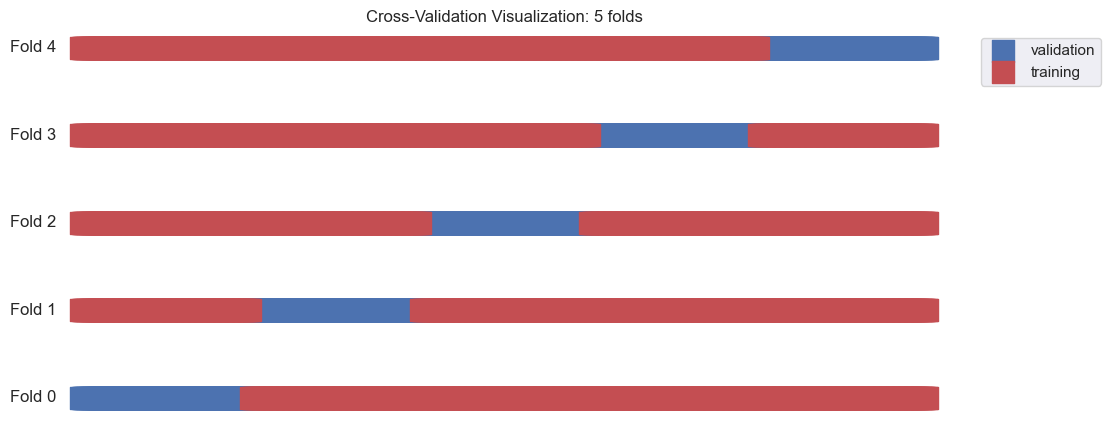

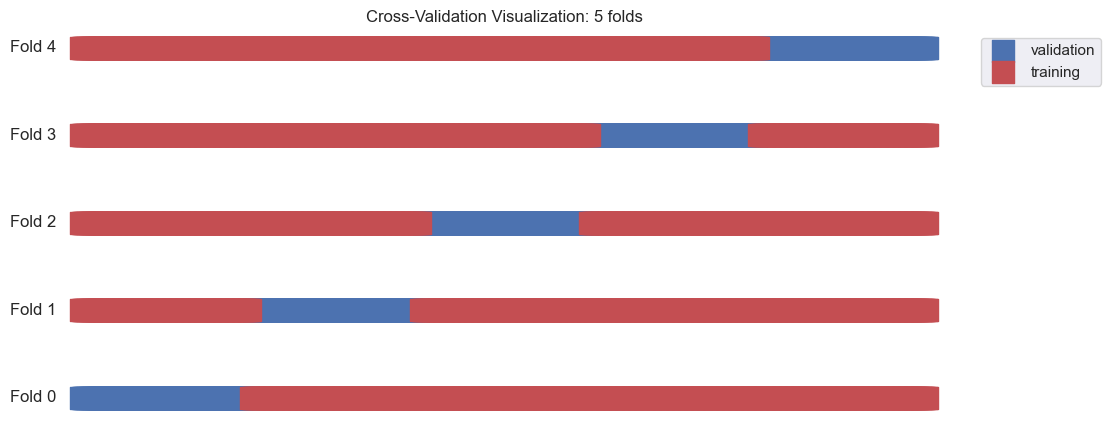

In [75]:
data_manager.splitter.plot_cross_validation(data_manager.data)

The code above prepares our Titanic dataset for cross-validation by dividing it into 5 folds.

Next, we use the ExperimentManager class. this time we will use a custom trainer - CVTrainer, with some additional parameters specified for our cross validation trainer.

In [76]:
exp_mang = ExperimentManager(
    data_manager,
    optimize_metric = MetricName.AUC,
    trainer = CVTrainer(aggregation = CVAggregation.MEAN, selected_model = CVSelectedModel.BEST)
)

In our CVTrainer, we are specifying two critical parameters:

aggregation: This parameter determines how to combine the performance metrics across the different folds. We can choose between 'mean', 'max', or 'min'. Here we've selected 'mean', which means the performance metrics in our results table will be the average performance across all folds.

selected_model: This parameter controls which model instance is returned from the cross-validation folds. It could either be the 'best' or the 'worst' performing model.

Once our experiment manager is defined, we can execute the experiment. Now, each model is not just trained and evaluated once, but across different distributions of the data.

In [77]:
exp_mang.run_experiment()

The results table provides the performance metrics for each model. Note that these metrics are aggregated according to our aggregation choice.

To visualize the variability of a model's performance across folds, we can use box plots. For instance, we can generate a box plot for the 'Logistic Regression' model using the AUC metric:

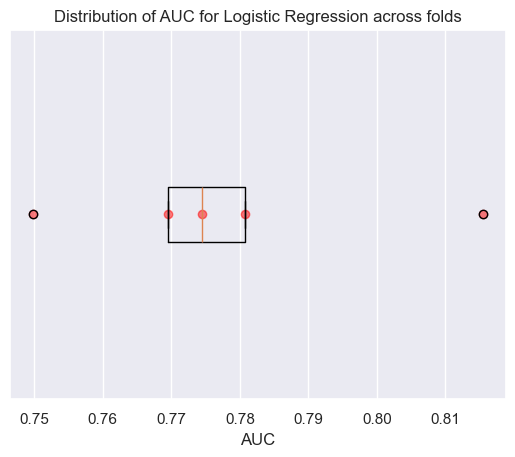

In [78]:
_ = exp_mang.trainer.box_plot_per_model_and_metric('Logistic Regression', 'AUC')

Finally, to visualize the cross-validation results for all models and metrics, we can plot the results:

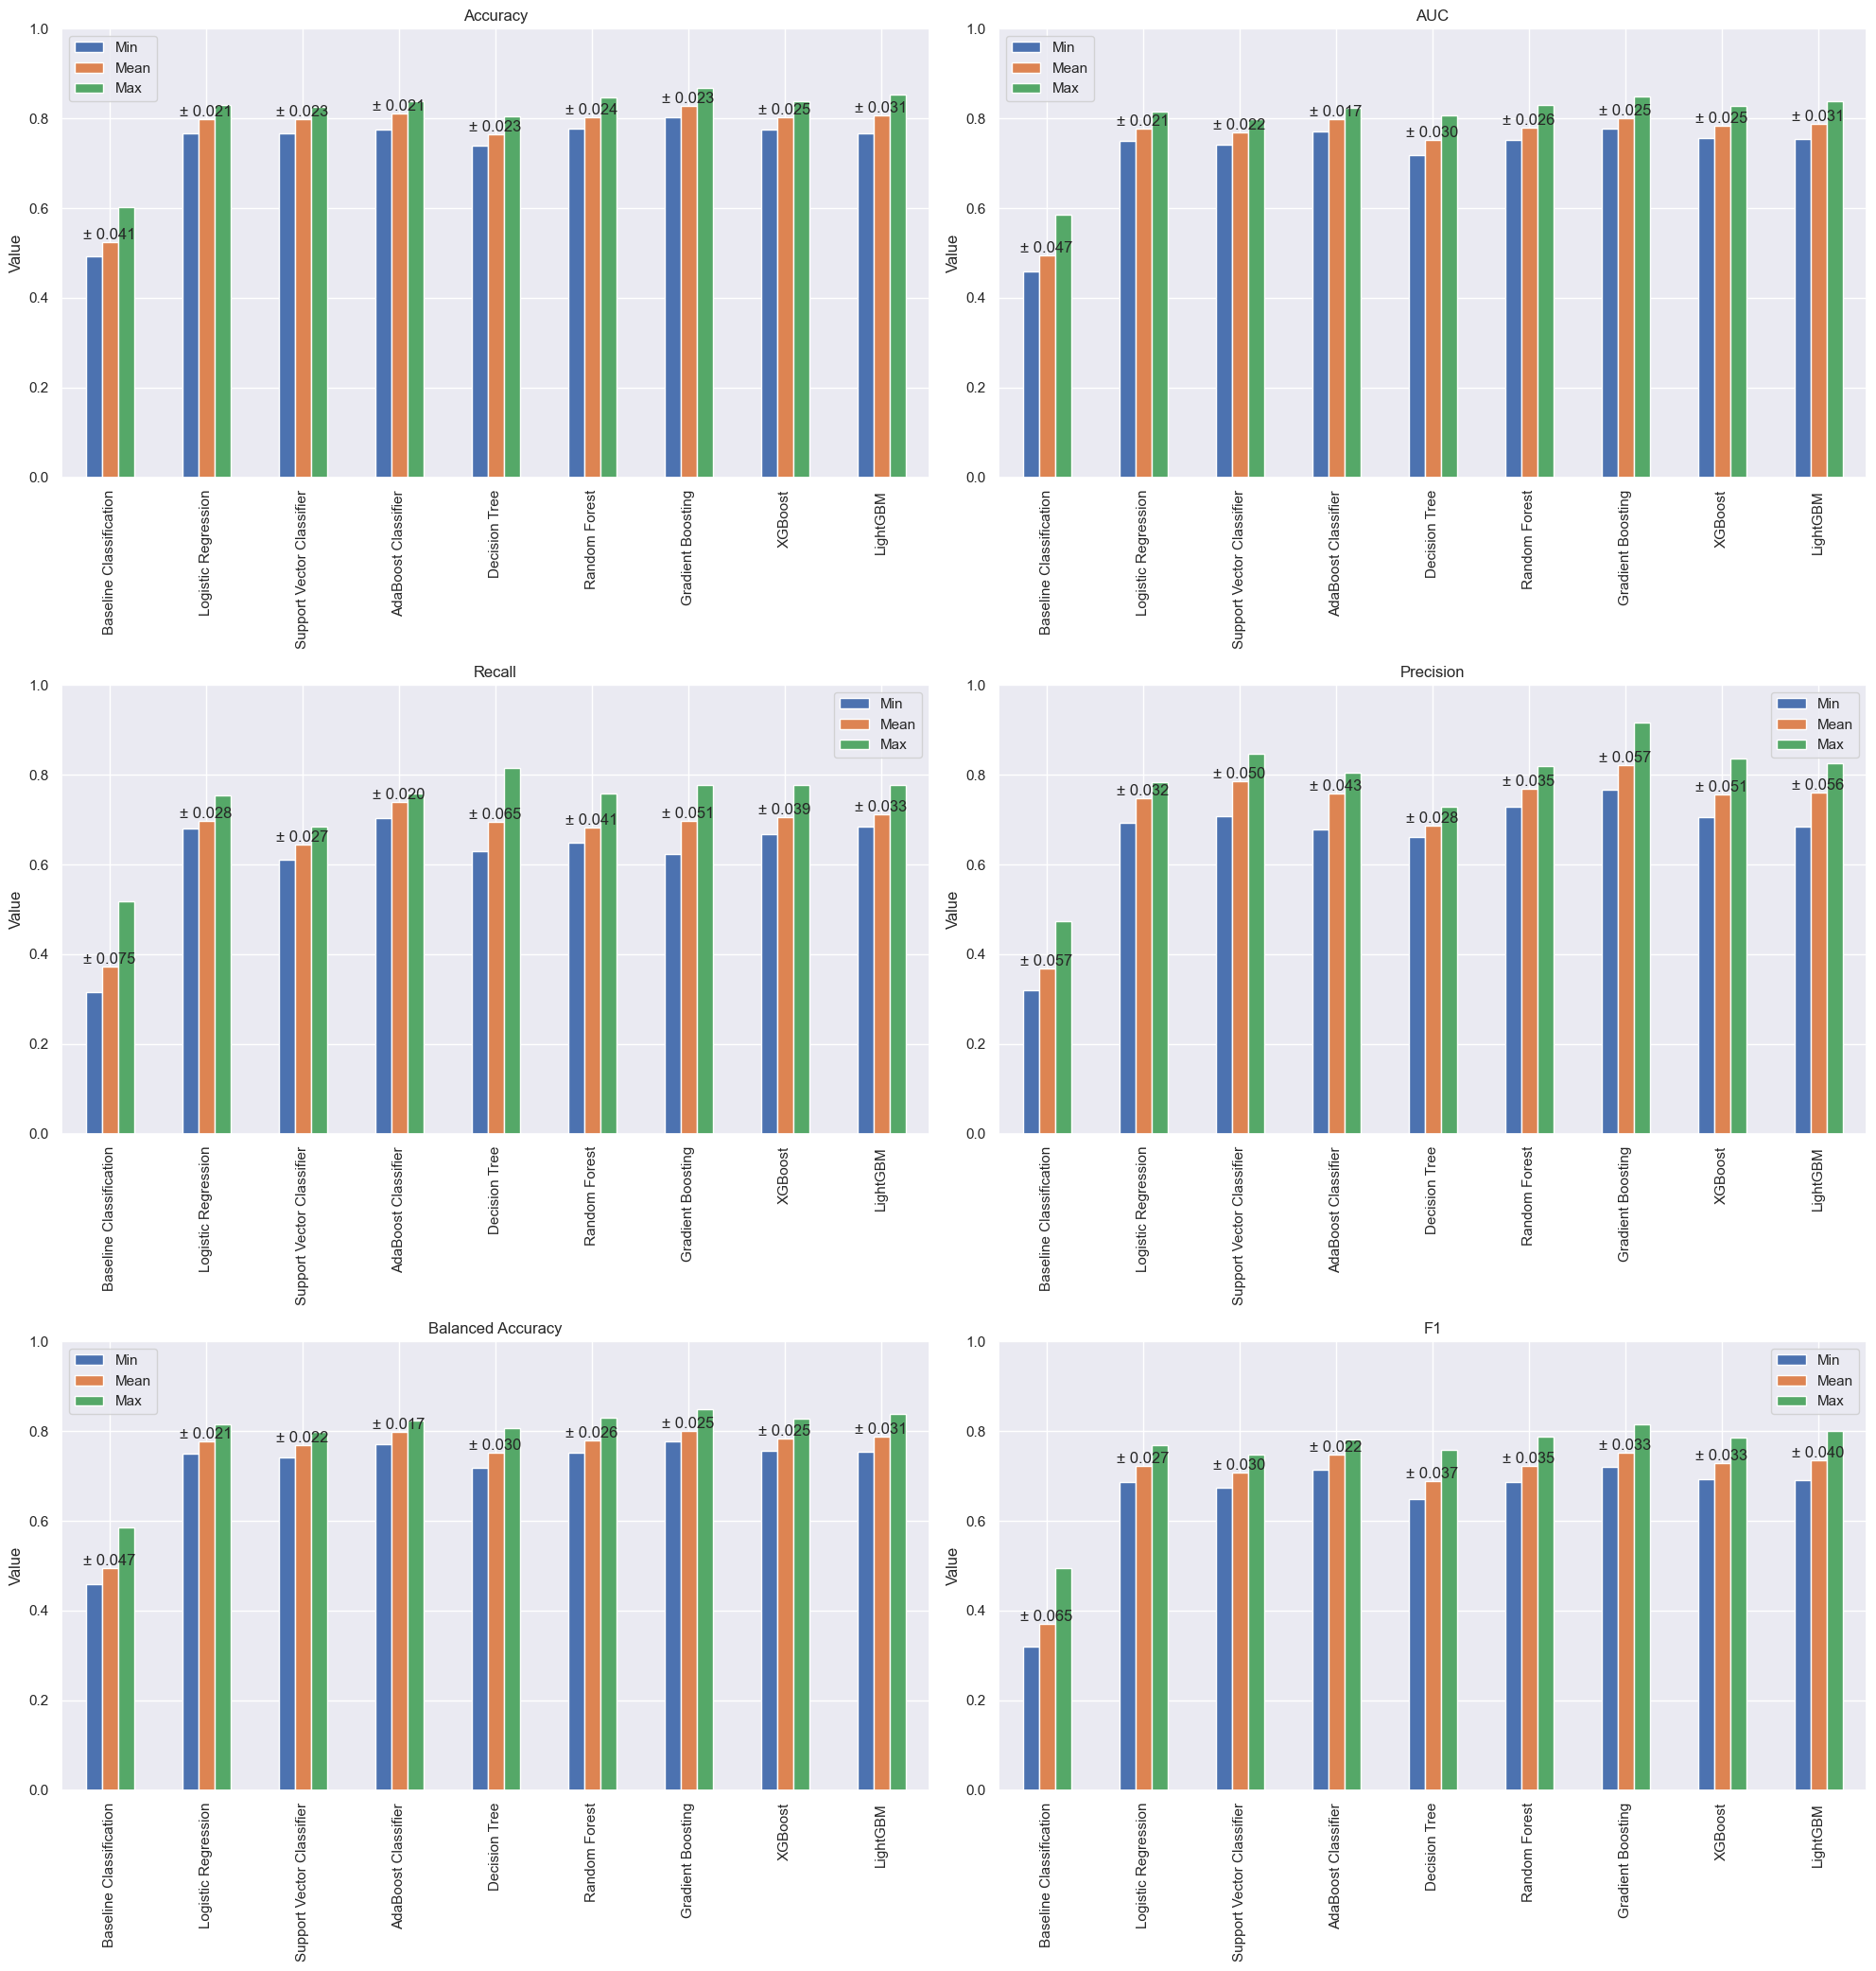

In [79]:
_ = exp_mang.trainer.plot_cv_res()

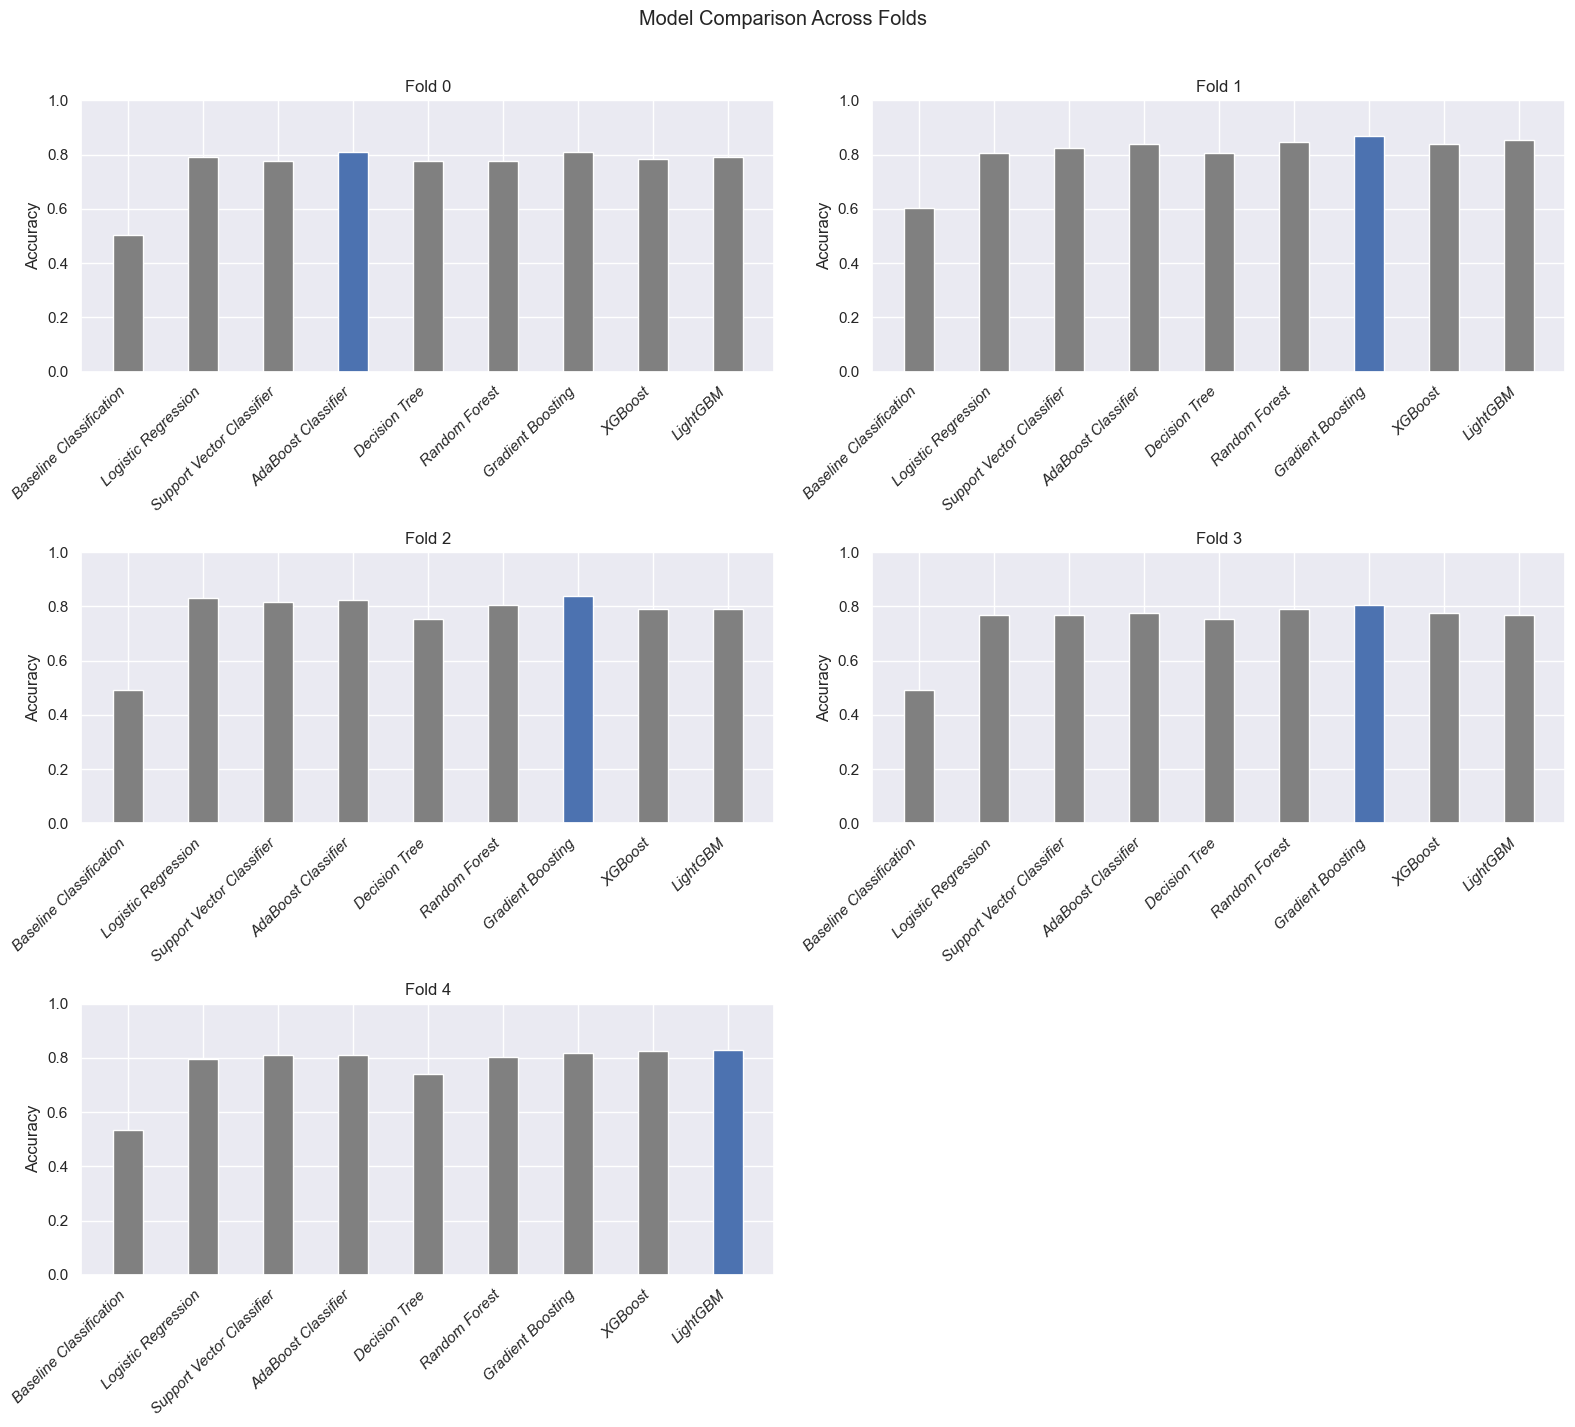

In [80]:
_ = exp_mang.trainer.display_best_models()

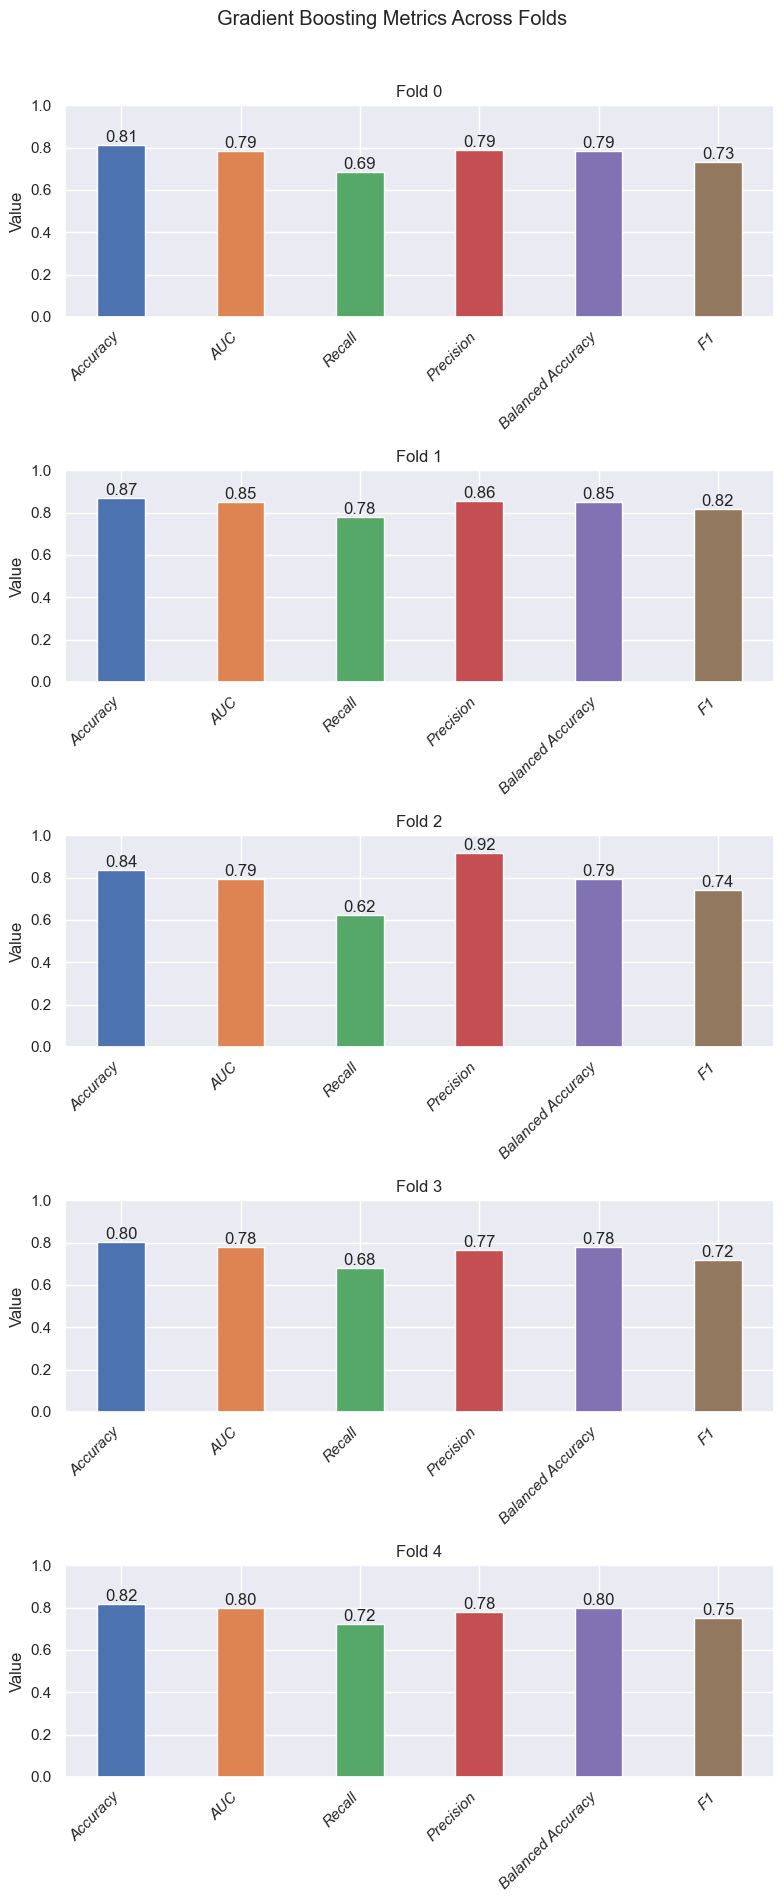

In [81]:
_ = exp_mang.trainer.display_model_cross_metrics('Gradient Boosting')

### Regression

In [82]:
data_manager = CrossValidationSupervisedTabularDataManager(data = DataSet.load_fetch_california_housing_dataset(),
                                            target = 'MedHouseVal',
                                            prediction_type = PredictionType.Regression)
data_manager.build_pipeline()
exp_mang = ExperimentManager(
    data_manager,
    optimize_metric = MetricName.MSE,
    trainer = CVTrainer(aggregation = CVAggregation.MEAN, selected_model = CVSelectedModel.BEST)
)
exp_mang.run_experiment()

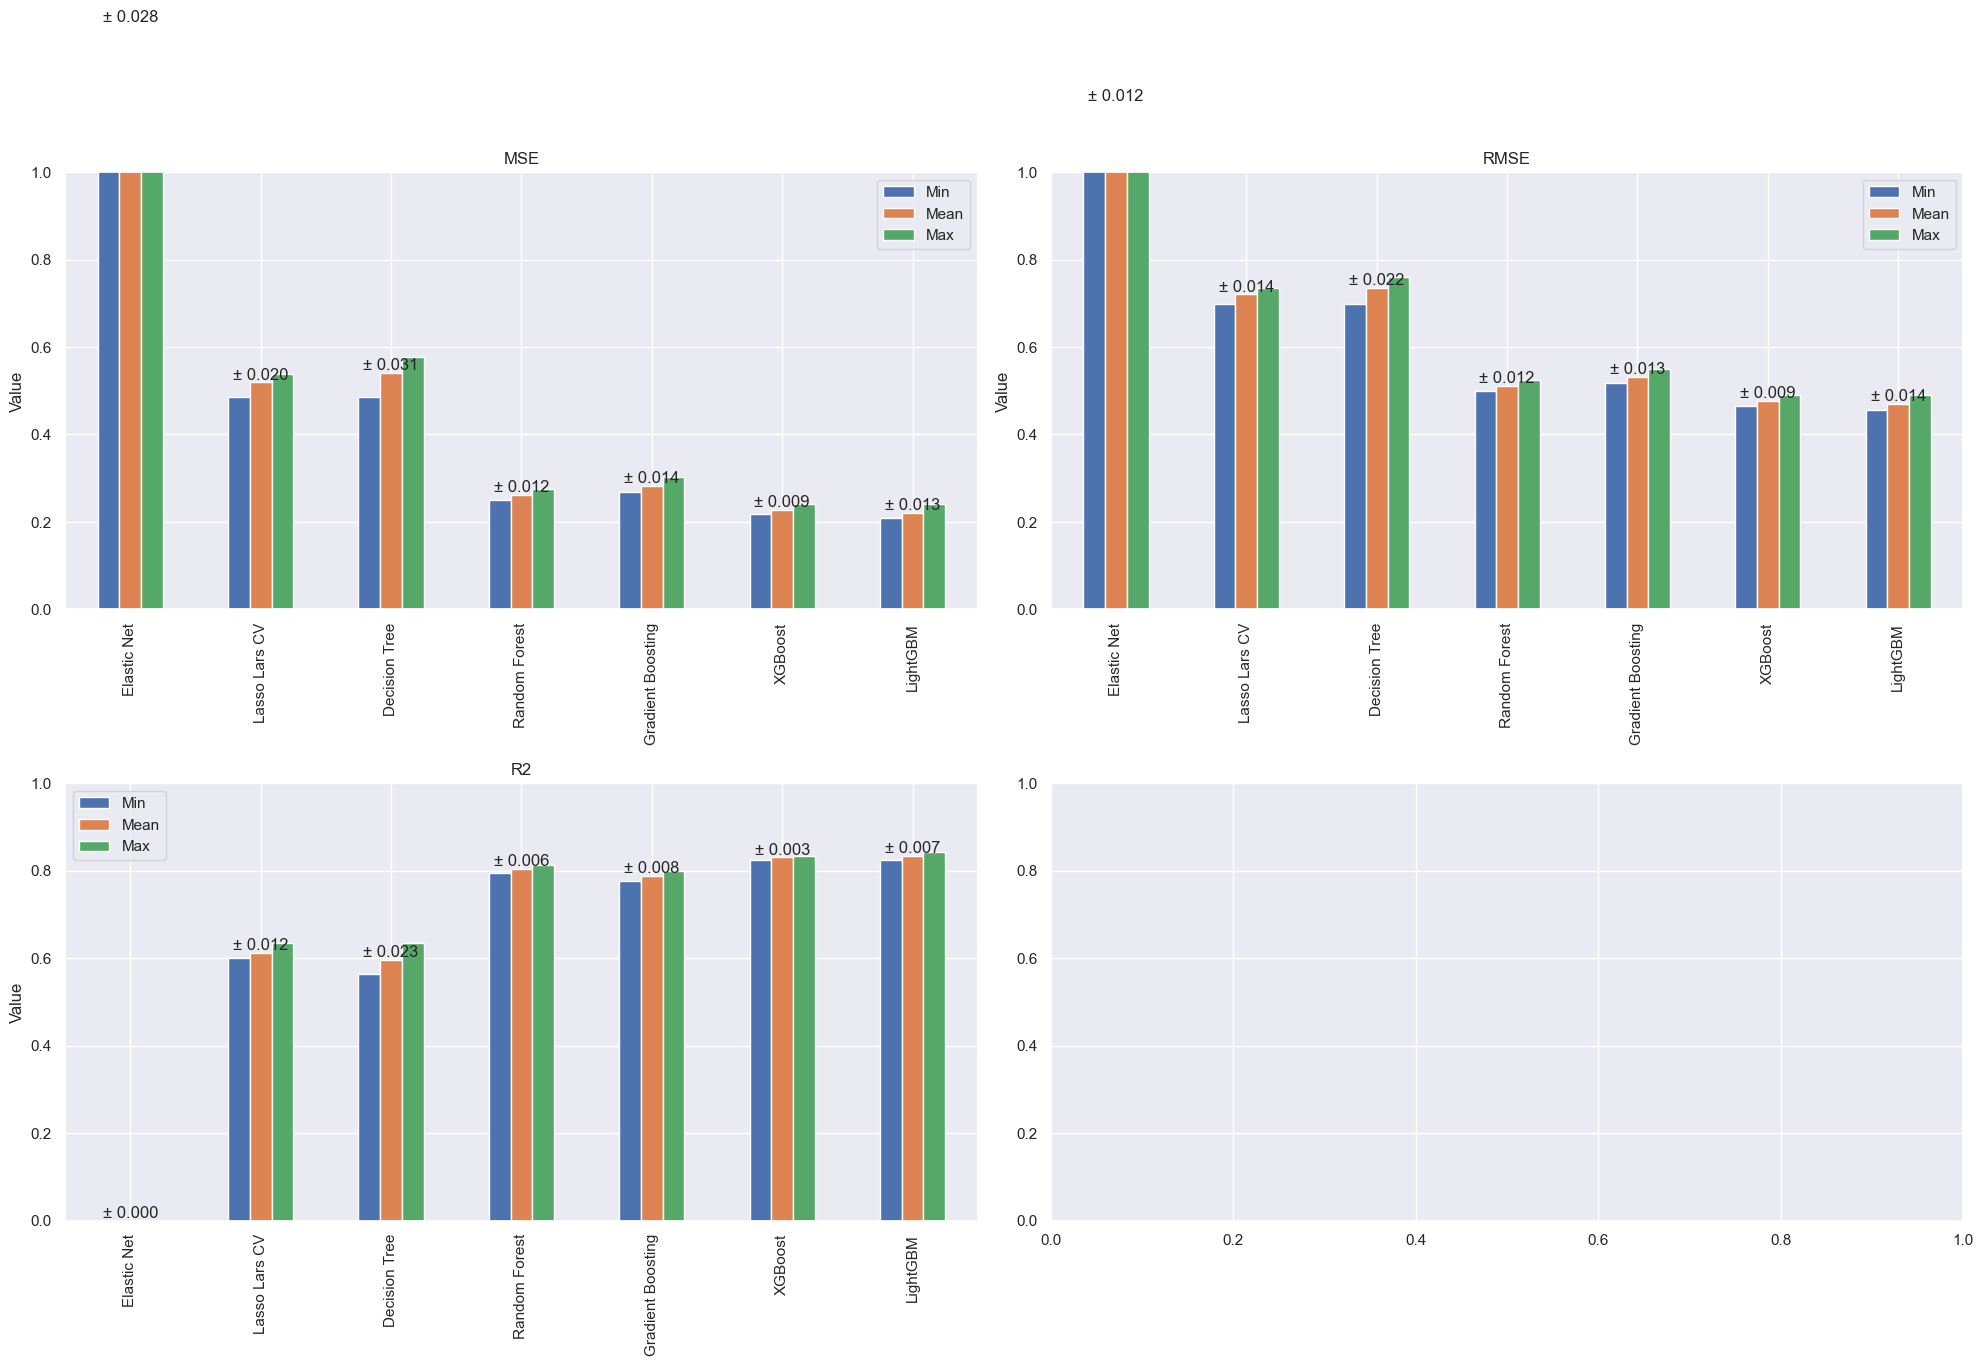

In [83]:
_ = exp_mang.trainer.plot_cv_res()

In conclusion, by incorporating cross-validation, we make our model evaluation process more comprehensive and robust, providing a solid foundation for reliable model selection.